In [1]:
import gamspy as gp
import gamspy.math as gpm
from gamspy import Sum, Card, Container, Options, Problem, Sense


import sys
import numpy as np
import pandas as pd
import math
import itertools

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import contextily as ctx

# Amazon Drone Optimization

## By: Sam Jenkins, Nandini Jagtiani

## 1. Introduction

The use of drones for commercial package delivery has grown significantly in recent years, with major companies such as Amazon leading the charge in utilizing this technology for faster and more efficient supply chain logistics and deliveries. As the demand for drone deliveries is projected to increase in the near future, so does the need for optimizing their operations. The primary challenge is to reduce energy consumption while ensuring that drones complete their deliveries on time and within the constraints imposed by real-world factors. This report addresses the optimization of drone delivery routes, focusing on minimizing energy consumption and maximizing efficiency, all while adhering to several technical and external constraints.

Our project, the Madison Drone Delivery Optimization, focuses on aiding the process by designing an efficient routing model for drones delivering packages to various locations. Using a set of 16 predefined delivery points in Madison, we aimed to minimize trips while accounting for constraints such as payload capacity and drone range limits. To achieve this, we utilized geospatial data, employing latitude and longitude coordinates along with a Haversine function to calculate accurate distances between locations. These distances formed the foundation of our distance matrix, which guided the development of feasible delivery routes.

By generating a dataset of potential routes, factoring in payload constraints of ≤5 lbs per drone, and identifying which drones could complete specific routes based on their range, we created the groundwork for a classical vehicle routing model adapted for drones. Our project not only showcases the application of optimization techniques to solve modern logistical challenges but also highlights the potential of drones to revolutionize delivery systems in urban areas.

In [2]:
options = Options(equation_listing_limit=0)
m = Container(options=options,debugging_level='keep')

In [3]:
drone = pd.read_csv("drone.csv")
loc = pd.read_csv("location.csv")

drone_df = pd.DataFrame(drone)
loc_df = pd.DataFrame(loc)

## 2. Model Description

Our approach was broken down into multiple tasks which allowed us to see progress every step of the way. Below we’ve laid out our methodology in chronological order, followed by the nitty gritty details of how we accomplished each step of the process together.

### 2.1. Location Data

Locations were determined by some of our most favorite (Camp Randall) and most notorious (The Kollege Klub) places on campus. Each location comes complete with a unique Amazon order, outside of Sam and Nandini who both wanted to read up on the History of Optimization!

Each order is given a payload, realistic to it's listing on Amazon

### 2.2. Research on real world Amazon drone constraints

In developing our drone delivery model, we incorporated the real-world constraints of Amazon's MK30 and MK27 drones, focusing on payload capacity, speed, weather tolerance, and range. The payload limit of 5 lbs (2.27 kg) dictated the weight constraint and number of packages per flight, while the both drone's share a maximum speed of 50 mph. The MK30's advanced weather tolerance allowed operations in rain, enhancing reliability compared to the MK27. The MK30's range of 32.1 km, double that of the MK27's 16.1 km, for significantly expanded delivery coverage. Due to Amazon's proprietary battery speficiations, we estimated how much energy is needed to fully charge both drones. Energy consumption is measured in watt-hours, a watt-hour is a unit of energy, representing how much power is used or generated over the course of an hour. If something consumes 1 watt of power continuously for 1 hour, it uses 1 watt-hour of energy. The MK30 needs 840 Wh to fully charge, while the MK27 requires 560 Wh.

In [4]:
locations = list(loc_df["Location"])
models = list(drone_df["Drone Models"])
loc_df.index = locations
drone_df.index = models
loc_df = loc_df.drop(columns = "Location")
drone_df = drone_df.drop(columns = "Drone Models")
display(loc_df)
display(drone_df)

,Latitude,Longitude,Payload,Demand
Camp Randall,43.070227,-89.412687,5.0000,5 Footballs
Sam's Apartment,43.075462,-89.393407,2.6250,History of Optimization book
3006 Sunrise Ct,43.108656,-89.473928,5.0000,Bird Food
Kohl Center,43.069709,-89.396907,4.6875,5 New Basketball Jerseys
Computer Sciences Building,43.071286,-89.406561,4.9360,8 NVIDIA Jetsons
Noland Hall,43.071678,-89.404489,1.5000,4 cups of Pepper Seeds
Lake Mendota,43.107811,-89.419515,4.0000,Fishing Rod
The Kollege Klub,43.075951,-89.397279,3.7500,Bottle of NA Vodka
Tenney Park,43.092186,-89.367120,2.2000,Drinking Fountain Filter
The Bakke,43.076852,-89.420159,3.4500,5 BUCKS Pre Workout


,Carrying Capacity,Fly in Rain,Speed,Radius,Charging Current
MK30,5,1,80.47,32.1,840
MK27,5,0,80.47,16.1,560


In [5]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c

# Define depot and charging station
depot = {"DWI 4": (43.103263, -89.323598)}
sellery_location = [43.075182, -89.400503]

# Consumer locations with payload weights
locations = {
    "Camp Randall": (43.070227, -89.412687, 5.0),
    "Sam's Apartment": (43.075462, -89.393407, 2.6250),
    "3006 Sunrise Ct": (43.108656, -89.473928, 5.0000),
    "Kohl Center": (43.069709, -89.396907, 4.6875),
    "Computer Sciences Building": (43.071286, -89.406561, 4.936),
    "Noland Hall": (43.071678, -89.404489, 1.5000),
    "Lake Mendota": (43.107811, -89.419515, 4.0000),
    "The Kollege Klub": (43.075951, -89.397279, 3.75),
    "Tenney Park": (43.092186, -89.367120, 2.2000),
    "The Bakke": (43.076852, -89.420159, 3.4500),
    "The Nick": (43.070881, -89.399039, 4.16),
    "Governer's Mansion": (43.113096, -89.370588, 0.7000),
    "Wisconsin State Capital": (43.076583, -89.384819, 5.0000),
    "Henry Vilas Zoo": (43.060791, -89.410046, 3.0000),
    "The Edgewater": (43.079474, -89.389944, 3.4000),
    "Nandini's Apartment": (43.069867, -89.394065, 2.6250),
    "Sellery": (43.075182, -89.400503, 0),
    "DWI 4": (43.103263, -89.323598, 0)
}

# Max initial ranges
initial_range_mk27 = 16.1
initial_range_mk30 = 32.1


### 2.3. Development of synthetic delivery and drone data

To address our vehicle routing problem, we compiled a dataset of 16 locations around Madison defined by their latitude and longitude coordinates and payload. Using the Haversine formula, which calculates distances between two points on a sphere, we generated a distance matrix showing the distances in kilometers (the standard metric) between all locations. This matrix served as the foundation for evaluating routes and ensuring feasibility. Additionally, we created a dataframe of all possible routes, ensuring payloads of <= 5 lbs while factoring in the range limitations of each drone. Each route was assigned the drone that could feasibly operate each route (MK30 or Both) because there is no MK27 path that the MK30 cannot take. These datasets, combining distance, payload, and range data, were essential for formulating a classical vehicle routing model.

In [6]:
def calculate_distance_matrix(locations):
    location_names = list(locations.keys())
    distance_matrix = pd.DataFrame(index=location_names, columns=location_names, dtype=float)
    
    # Fill the DataFrame with distances
    for loc1, loc2 in itertools.combinations(location_names, 2):
        lat1, lon1 = locations[loc1][:2]
        lat2, lon2 = locations[loc2][:2]
        distance = haversine(lat1, lon1, lat2, lon2)
        
        # Assign distances symmetrically
        distance_matrix.loc[loc1, loc2] = distance
        distance_matrix.loc[loc2, loc1] = distance
        
    # Fill diagonal with zeros (distance from a location to itself)
    distance_matrix.fillna(0, inplace=True)
    
    return distance_matrix

distance_matrix = calculate_distance_matrix(locations)
display(distance_matrix)

,Camp Randall,Sam's Apartment,3006 Sunrise Ct,Kohl Center,Computer Sciences Building,Noland Hall,Lake Mendota,The Kollege Klub,Tenney Park,The Bakke,The Nick,Governer's Mansion,Wisconsin State Capital,Henry Vilas Zoo,The Edgewater,Nandini's Apartment,Sellery,DWI 4
Camp Randall,0.000000,1.670730,6.556717,1.283105,0.511353,0.685181,4.215772,1.404078,4.433676,0.954476,1.111001,5.865889,2.371363,1.070945,2.114153,1.513196,1.132698,8.113906
Sam's Apartment,1.670730,0.000000,7.508253,0.700032,1.164985,0.993626,4.175304,0.319160,2.831189,2.178340,0.684650,4.576557,0.708586,2.118531,0.527378,0.624427,0.577199,6.456905
3006 Sunrise Ct,6.556717,7.508253,0.000000,7.607455,6.869697,6.978635,4.418215,7.208503,8.862993,5.618606,7.390887,8.403234,8.066826,7.432470,7.552009,7.788551,7.028655,12.218878
Kohl Center,1.283105,0.700032,7.607455,0.000000,0.803556,0.653639,4.617416,0.694736,3.478365,2.048878,0.216738,5.276588,1.244301,1.456918,1.224281,0.231524,0.675037,7.025834
Computer Sciences Building,0.511353,1.164985,6.869697,0.803556,0.000000,0.173857,4.195409,0.915145,3.957428,1.266079,0.612659,5.490554,1.861625,1.200840,1.628062,1.027232,0.655595,7.617916
Noland Hall,0.685181,0.993626,6.978635,0.653639,0.173857,0.000000,4.198998,0.754135,3.796150,1.396776,0.451478,5.365458,1.688219,1.292008,1.465313,0.870349,0.506590,7.448851
Lake Mendota,4.215772,4.175304,4.418215,4.617416,4.195409,4.198998,0.000000,3.976262,4.595092,3.442881,4.430290,4.014962,4.471569,5.284634,3.961538,4.698150,3.942971,7.803234
The Kollege Klub,1.404078,0.319160,7.208503,0.694736,0.915145,0.754135,3.976262,0.000000,3.042661,1.861049,0.581601,4.664400,1.014461,1.979191,0.713005,0.725134,0.275470,6.709828
Tenney Park,4.433676,2.831189,8.862993,3.478365,3.957428,3.796150,4.595092,3.042661,0.000000,4.632542,3.511723,2.342071,2.253025,4.933824,2.330995,3.308778,3.305303,3.742207
The Bakke,0.954476,2.178340,5.618606,2.048878,1.266079,1.396776,3.442881,1.861049,4.632542,0.000000,1.839474,5.695863,2.870513,1.965782,2.471299,2.257332,1.607266,8.373013


In [7]:
def get_possible_routes():
    possible_routes = []
    unique_routes_set = set()

    consumers = list(locations.keys())[:-2]

    # Generate all subsets of consumers
    for r in range(1, len(consumers) + 1):
        for subset in itertools.combinations(consumers, r):
            total_payload = sum(locations[consumer][2] for consumer in subset)

            # Skip if total payload exceeds 5 lbs
            if total_payload > 5:
                continue

            sorted_route = tuple(sorted(subset))
            if sorted_route in unique_routes_set:
                continue
            unique_routes_set.add(sorted_route)

            total_distance = 0
            start_lat, start_lon = depot["DWI 4"]
            route_with_recharge = ["DWI 4"]
            for consumer in subset:
                consumer_lat, consumer_lon = locations[consumer][:2]
                total_distance += haversine(start_lat, start_lon, consumer_lat, consumer_lon)
                start_lat, start_lon = consumer_lat, consumer_lon
                route_with_recharge.append(consumer)
            adjusted_range_mk30 = initial_range_mk30 * (1 - total_payload / 100)
            adjusted_range_mk27 = initial_range_mk27 * (1 - total_payload / 100)

            if total_distance > adjusted_range_mk30:
                route_with_recharge.append("Sellery")
                total_distance += haversine(start_lat, start_lon, sellery_location[0], sellery_location[1])
                start_lat, start_lon = sellery_location
                total_distance = 0
            total_distance += haversine(start_lat, start_lon, depot["DWI 4"][0], depot["DWI 4"][1])
            route_with_recharge.append("DWI 4")
            mk30_feasible = total_distance <= adjusted_range_mk30
            mk27_feasible = total_distance <= adjusted_range_mk27

            drone_type = None
            if mk30_feasible and mk27_feasible:
                drone_type = "Both"
            elif mk30_feasible:
                drone_type = "MK30"
            elif mk27_feasible:
                drone_type = "MK27"

            if drone_type:
                possible_routes.append({
                    "Route": tuple(route_with_recharge),
                    "Payload (lbs)": total_payload,
                    "Total Distance (km)": total_distance,
                    "Drone Type": drone_type
                })

    return possible_routes

routes = get_possible_routes()
routes_df = pd.DataFrame(routes)
routes_df.to_csv('routes.csv', index=False)
display(routes_df)

,Route,Payload (lbs),Total Distance (km),Drone Type
0,"(DWI 4, Camp Randall, DWI 4)",5.0000,16.227811,MK30
1,"(DWI 4, Sam's Apartment, DWI 4)",2.6250,12.913810,Both
2,"(DWI 4, 3006 Sunrise Ct, DWI 4)",5.0000,24.437757,MK30
3,"(DWI 4, Kohl Center, DWI 4)",4.6875,14.051669,Both
4,"(DWI 4, Computer Sciences Building, DWI 4)",4.9360,15.235831,Both
5,"(DWI 4, Noland Hall, DWI 4)",1.5000,14.897702,Both
6,"(DWI 4, Lake Mendota, DWI 4)",4.0000,15.606467,MK30
7,"(DWI 4, The Kollege Klub, DWI 4)",3.7500,13.419655,Both
8,"(DWI 4, Tenney Park, DWI 4)",2.2000,7.484415,Both
9,"(DWI 4, The Bakke, DWI 4)",3.4500,16.746026,MK30


## 3. Optimization Model

The model contains sets displaying 2 drones (1 MK30, 1 MK27) a common tactic used by prime air in test cities. A set of all locations within the above Location dataframe, as well as a set displaying the possible delivery routes that a drone can take. The code chunk below initilizes a object "Customer Route Tuples", this maps which routes covers which customers, allowing the creation of the set which is necessary for the "Cover Constraint" ensuring each customer is delivered their items.

Our model was created with the goal of minimizing energy consumption, the less drones that deliver packages means that we will use less energy therefore the model attempts to minimize the amount of routes necessary to ensure delivery of all items, this is done with respect to many constraints including the fact that each delivery can only be made by one drone at a time before returning to the depot to pick up the next package

The largest challenge of the model was to create a working "Battery Drain Constraint" initally we attempted to formulate the following equation 
$$
B_{j,k} = B_{i,k} - \left( \frac{D_{i,j}}{\text{Range}} + \alpha \cdot \text{payload}_i \right) \cdot X_{i,j}
$$
This proved difficult with our model, due to the challenge of determining the payload from location to location. We attempted to solve this issue by creating a payload matrix. Yet the payload from the Depot to the initial delivery location is not the same in all cases. Due to this the battery constraint is formulated in post-processing of our optimization model.

Other battery constraints include beginning the day with a charge level of 100, and ensuring that the battery level never drops below 0

Pesky weather always comes into play around Madison. We've decided that a third of the routes will have to go through rain, for these routes only the MK30 drone can make the trip. 

In [8]:
# Mapping location names to integers
location_to_int = {
    "DWI 4": 1,
    "Camp Randall": 2,
    "Sam's Apartment": 3,
    "3006 Sunrise Ct": 4,
    "Kohl Center": 5,
    "Computer Sciences Building": 6,
    "Noland Hall": 7,
    "Lake Mendota": 8,
    "The Kollege Klub": 9,
    "Tenney Park": 10,
    "The Bakke": 11,
    "The Nick": 12,
    "Governer's Mansion": 13,
    "Wisconsin State Capital": 14,
    "Henry Vilas Zoo": 15,
    "The Edgewater": 16,
    "Nandini's Apartment": 17,
    "Sellery": 18,
}

# Generate tuples of customers (as integers) and their corresponding routes
def generate_customer_route_tuples(routes_df):
    customer_route_tuples = []

    # Iterate over each row in the DataFrame
    for route_index, route in routes_df.iterrows():
        route_customers = route['Route']  # Get the list of customer names for this route
        
        # Initialize a flag to check if DWI 4 (18) has been added
        dwi4_added = False

        for customer in route_customers:
            customer_int = location_to_int[customer]  # Map customer name to integer
            
            # Only add DWI 4 once for the route
            if customer_int == 1 and not dwi4_added:
                customer_route_tuples.append((f'r{route_index + 1}', str(customer_int)))  # Reverse tuple order
                dwi4_added = True
            elif customer_int != 1:
                customer_route_tuples.append((f'r{route_index + 1}', str(customer_int)))  # Reverse tuple order

    return customer_route_tuples




# Generate the customer-route tuples
location_route_tuples = generate_customer_route_tuples(routes_df)
customer_route_tuples = [tuple for tuple in location_route_tuples if tuple[1] != '1']
distance_list = routes_df["Total Distance (km)"].tolist()
payload_list = loc_df["Payload"].tolist()
radius = {"1": 32.1, "2": 16.1}

### 3.1. Objective

The Objective function aims to minimize the number of trips that are necessary to ensure delivery of all products. We formulated the model this way for simplicity, while understanding that energy consumption and trips have a direct correlation.

In [9]:
#STEP 1: DEFINE BASIC SETS
#We have 2 drones - one MK30 (k=1) and one MK27 (k=2)
k = m.addSet('k', records=[i+1 for i in range(2)], 
             description='Available drones (1=MK30, 2=MK27)')

#Define locations: 18 total locations including delivery points, depot, and charging stations
i = m.addSet('i', records=[i+1 for i in range(18)], 
             description='All locations in Madison area')

#Define 16 customers who need deliveries (excluding depot and charging station)
s = m.addSet('s', records=[i+2 for i in range(16)], 
             description='Customer delivery locations')

#Define 37 possible delivery routes
j = m.addSet('j', records=['r'+str(i+1) for i in range(37)], 
             description='All possible delivery routes')

#STEP 2: DEFINE DRONE CAPABILITIES
#Set drone ranges (how far they can fly on one charge)
mk30_range = m.addParameter("mk30_range", records=32.1)
mk27_range = m.addParameter("mk27_range", records=16.1)

#STEP 3: ROUTE-LOCATION RELATIONSHIPS
#L shows which locations are in each route
L = m.addSet('L', [j, i], records=location_route_tuples)

#C shows which customers are served by each route
C = m.addSet('C', [j, s], records=customer_route_tuples)

#STEP 4: DECISION VARIABLES
x = m.addVariable('x', 'binary', domain=[j, k], 
                 description="x[j,k] = 1 if drone k takes route j")
y = m.addVariable('y', 'binary', domain=[i, k], 
                 description="y[i,k] = 1 if drone k visits location i")
b = m.addVariable('b', 'positive', domain=[k], 
                 description="Battery level of drone k")

#STEP 5: ROUTING CONSTRAINTS
#Ensure routes and locations match
location_route_link_1 = m.addEquation('location_route_link_1', domain=[i, k, j])
location_route_link_1[i, k, j] = y[i, k] >= x[j, k] * L[j, i]

location_route_link_2 = m.addEquation('location_route_link_2', domain=[i, k])
location_route_link_2[i, k] = y[i, k] <= Sum(j, L[j, i] * x[j, k])

#Every customer must be served exactly once
cover = m.addEquation('cover', domain=[s])
cover[s] = Sum((j, k), C[j, s] * x[j, k]) == 1

#Each route can be assigned to at most one drone
route_assignment = m.addEquation('route_assignment', domain=[j])
route_assignment[j] = Sum(k, x[j, k]) <= 1

#STEP 6: DISTANCE AND BATTERY CONSTRAINTS
#Record the distance for each route
route_distance_records = [{
    'j': f'r{i+1}',
    'value': distance_list[i]
} for i in range(len(distance_list))]

route_distance = m.addParameter("route_distance", domain=[j], 
                              records=route_distance_records)

#Battery constraints - simplified
#All drones start fully charged
battery_init = m.addEquation('battery_init', domain=[k])
battery_init[k] = b[k] == 100

#Battery can't go negative
positive_battery = m.addEquation('positive_battery', domain=[k])
positive_battery[k] = b[k] >= 0

#MK27 has shorter range than MK30
mk27_range_limit = m.addEquation('mk27_range_limit', domain=[j])
mk27_range_limit[j] = x[j, "2"] * (route_distance[j] / mk27_range) <= 1

#STEP 7: PAYLOAD CONSTRAINTS
#Record payload weights for each route
route_payload_records = [{
    'j': f'r{i+1}',
    'value': routes_df['Payload (lbs)'].iloc[i]
} for i in range(len(payload_list))]

route_payload = m.addParameter("route_payload", domain=[j], 
                             records=route_payload_records)

#Each drone has 5 lb payload limit
payload_capacity = m.addEquation('payload_capacity', domain=[j, k])
payload_capacity[j, k] = x[j, k] * route_payload[j] <= 5

#STEP 8: OPERATIONAL CONSTRAINTS
#Each drone can handle between 5 and 7 routes
max_routes_per_drone = m.addEquation('max_routes_per_drone', domain=[k])
max_routes_per_drone[k] = Sum(j, x[j, k]) <= 7

balance_workload = m.addEquation('balance_workload', domain=[k])
balance_workload[k] = Sum(j, x[j, k]) >= 5

#STEP 9: WEATHER CONSTRAINTS
#Mark routes with rain (every third route for this example)
rain_route_records = [{
    'j': f'r{i+1}',
    'value': 1 if i % 3 == 0 else 0
} for i in range(len(distance_list))]

rain_routes = m.addParameter("rain_routes", domain=[j], 
                           records=rain_route_records)

#MK27 (k=2) cannot fly in rain
rain_constraint = m.addEquation('rain_constraint', domain=[j])
rain_constraint[j] = x[j, '2'] * rain_routes[j] <= 0

#STEP 10: SOLVE MODEL
setcover = m.addModel('setcover',
    equations=m.getEquations(),
    problem=Problem.MIP,
    sense=Sense.MIN,
    objective=Sum([j, k], x[j, k])  # minimizing number of routes
)

#Solve the model
setcover.solve(output=None, options=Options(absolute_optimality_gap=0.999))

#STEP 11: ANALYZE ROUTES
x_df = pd.DataFrame(x.records)
active_routes = x_df[x_df['level'] > 0.5]

print(f"\nModel Status: {setcover.status}")
print(f"Objective Value: {setcover.objective_value}")
print("\nRoute Assignments:")
print(active_routes)
x.records.to_csv('optimal.csv', index=False)


Model Status: ModelStatus.OptimalGlobal
Objective Value: 13.0

Route Assignments:
      j  k  level  marginal  lower  upper  scale
0    r1  1    1.0       1.0    0.0    1.0    1.0
3    r2  2    1.0       1.0    0.0    1.0    1.0
4    r3  1    1.0       1.0    0.0    1.0    1.0
6    r4  1    1.0       1.0    0.0    1.0    1.0
9    r5  2    1.0       1.0    0.0    1.0    1.0
12   r7  1    1.0       1.0    0.0    1.0    1.0
18  r10  1    1.0       1.0    0.0    1.0    1.0
21  r11  2    1.0       1.0    0.0    1.0    1.0
24  r13  1    1.0       1.0    0.0    1.0    1.0
26  r14  1    1.0       1.0    0.0    1.0    1.0
47  r24  2    1.0       1.0    0.0    1.0    1.0
53  r27  2    1.0       1.0    0.0    1.0    1.0
57  r29  2    1.0       1.0    0.0    1.0    1.0


### 3.2. Energy Consumption

As mentioned above the battery constraint was giving us troubles within the model due to payload. This was a catalyst for the creation of a parameter Delta. Delta stores that amount of charge needed for each drone after each specific delivery has occured. Delta is populated with the following simple equation


$$
\text{Battery Used (\%)} = \left( \frac{\text{Distance}}{\text{Drone Range}} \right) \cdot 100
$$

$$
\text{Battery Level After Route (\%)} = 100 - \text{Battery Used (\%)}
$$

Although the delta variable doesn't take payload into account, it shows approximately how much battery is being consumed by every delivery.

In [10]:
charging_records = []

# Function to analyze routes for each drone
def analyze_drone_routes(routes_df, drone_range, drone_type):
    route_analysis = []
    for _, row in routes_df.iterrows():
        route = row['j']
        distance = float(route_distance.records[route_distance.records['j'] == route]['value'].iloc[0])
        battery_used = (distance / drone_range) * 100
        battery_level_after_route = 100 - battery_used
        
        route_analysis.append({
            'Route': route,
            'Distance (km)': round(distance, 2),
            'Battery Used (%)': round(battery_used, 2),
            'Battery Level After Route (%)': round(battery_level_after_route, 2)
        })
    
    analysis_df = pd.DataFrame(route_analysis)
    print(f"\n{drone_type} Route Analysis:")
    print(analysis_df)
    print(f"Total Distance: {round(sum(analysis_df['Distance (km)']), 2)} km")
    print(f"Total Battery Used: {round(sum(analysis_df['Battery Used (%)']), 2)}%")
    print("=" * 50)
    return sum(analysis_df['Battery Used (%)'])

# For MK30 (k=1)
mk30_routes = x_df[(x_df['k'] == '1') & (x_df['level'] > 0.5)]
mk30_battery_used = analyze_drone_routes(mk30_routes, 32.1, "MK30 (k=1)")
mk30_charging = max(0, mk30_battery_used - 100)
charging_records.append({'k': '1', 'value': mk30_charging})

# For MK27 (k=2)
mk27_routes = x_df[(x_df['k'] == '2') & (x_df['level'] > 0.5)]
mk27_battery_used = analyze_drone_routes(mk27_routes, 16.1, "MK27 (k=2)")
mk27_charging = max(0, mk27_battery_used - 100)
charging_records.append({'k': '2', 'value': mk27_charging})

# Adding the parameter delta
delta = m.addParameter("delta", domain=[k], records=charging_records,
                       description="Charging needed for each drone type")

print("\nCharging Requirements (delta):")
print(delta.records)


MK30 (k=1) Route Analysis:
  Route  Distance (km)  Battery Used (%)  Battery Level After Route (%)
0    r1          16.23             50.55                          49.45
1    r3          24.44             76.13                          23.87
2    r4          14.05             43.77                          56.23
3    r7          15.61             48.62                          51.38
4   r10          16.75             52.17                          47.83
5   r13          11.58             36.07                          63.93
6   r14          16.92             52.72                          47.28
Total Distance: 115.58 km
Total Battery Used: 360.03%

MK27 (k=2) Route Analysis:
  Route  Distance (km)  Battery Used (%)  Battery Level After Route (%)
0    r2          12.91             80.21                          19.79
1    r5          15.24             94.63                           5.37
2   r11          14.21             88.28                          11.72
3   r24          14.92    

## 4. Sensitivity Analysis

Customer service is one of Amazon's key principles, it was crucial that all deliveries were made within the day. The following code extracts the total of time it took for all deliveries to be made. This includes the initial trip to the consumer, the trip back to the Depot and the recharging process. To determine recharging time we converted battery percentage used into the energy unit watt-hours (Wh).

Assuming the DWI 4 Amazon depot in Madison contains a 560 Watt charger for their continuous use of MK27 Drones a the waiting time for a full charge for both drones will be as follows

    MK27: 1 Hour

    MK30: 1 Hour 30 Minutes

The charging time for each drone is calculated using the following formulas:

$$
\text{MK30 Charging Time (minutes)} = \left( \frac{\text{MK30 Energy Required (Wh)}}{840} \right) \times 90
$$

$$
\text{MK27 Charging Time (minutes)} = \left( \frac{\text{MK27 Energy Required (Wh)}}{560} \right) \times 60
$$

Calculating the trip to the consumer was a far simplier task. Both drones maintain a maxiumum speed of 50 mph throughout deliveries constantly decrease within a mile radius of the home to a final speed of 1 mph. We were able to calculate the average speed of deliveries to be 35 mph. 

In [11]:
MK30_FULL_CAPACITY_WH = 840
MK27_FULL_CAPACITY_WH = 560 
KM_TO_MILES = 0.621371
DRONE_SPEED_MPH = 35 

delta_mk30_percentage = 260.03
delta_mk27_percentage = 437.23

mk30_energy_required_wh = (delta_mk30_percentage / 100) * MK30_FULL_CAPACITY_WH
mk27_energy_required_wh = (delta_mk27_percentage / 100) * MK27_FULL_CAPACITY_WH

print(f"Energy Consumption for MK30: {mk30_energy_required_wh:.2f} Wh")
print(f"Energy Consumption for MK27: {mk27_energy_required_wh:.2f} Wh")
print("=" * 50)
print(f"Total Energy Consumed: {mk30_energy_required_wh + mk27_energy_required_wh:.2f} Wh")

mk30_charging_time = (mk30_energy_required_wh / 840) * 90
mk27_charging_time = (mk27_energy_required_wh / 560) * 60

print("=" * 50)
print(f"Total Charging Time for MK30: {mk30_charging_time:.2f} min")
print(f"Total Charging Time for MK27: {mk27_charging_time:.2f} min")

selected_routes = [(row["j"], row["k"]) for index, row in x.records.iterrows() if row["level"] == 1.0]

routes_df['Route ID'] = ['r' + str(i + 1) for i in range(len(routes_df))]

routes_to_distances = {route_id: distance for route_id, distance in zip(routes_df['Route ID'], routes_df["Total Distance (km)"])}

selected_route_distances = []

for route, drone in selected_routes:
    if route in routes_to_distances:
        distance = routes_to_distances[route]
        selected_route_distances.append({
            "Route ID": route,
            "Drone Type": drone,
            "Distance (km)": distance
        })

for route in selected_route_distances:
    distance_miles = route["Distance (km)"] * KM_TO_MILES
    delivery_time_hours = distance_miles / DRONE_SPEED_MPH
    route["Delivery Time (hours)"] = round(delivery_time_hours, 2)

if route["Drone Type"] == '1':
    route["Delivery Time (hours)"] += (mk30_charging_time / 60)
elif route["Drone Type"] == '2':
    route["Delivery Time (hours)"] += (mk27_charging_time / 60)

total_delivery_time_hours = sum(route["Delivery Time (hours)"] for route in selected_route_distances)

selected_routes_df = pd.DataFrame(selected_route_distances)

print("=" * 50)
print(f"Total Delivery Time for Selected Routes: {round(total_delivery_time_hours, 2)} hours")


Energy Consumption for MK30: 2184.25 Wh
Energy Consumption for MK27: 2448.49 Wh
Total Energy Consumed: 4632.74 Wh
Total Charging Time for MK30: 234.03 min
Total Charging Time for MK27: 262.34 min
Total Delivery Time for Selected Routes: 7.96 hours


### 4.2. Route Visualization

The map below displays the routes taken by drones through downtown Madison, WI, as they visit each delivery location. The blue dots represent the locations of the delivery sites, black dotted lines show MK27 paths while the tan dotted lines show the MK30 paths. Each drone returns to the depot for a recharge before making the next delivery.

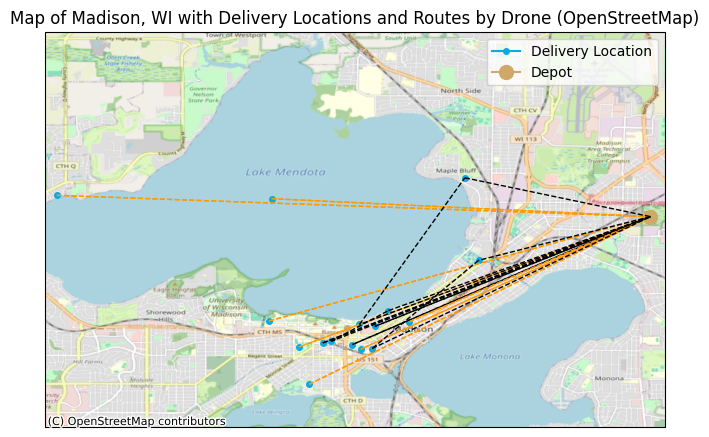

In [12]:
latitudes = list(loc_df["Latitude"])
longitudes = list(loc_df["Longitude"])
coordinates = list(zip(latitudes, longitudes))

delivery_coords = coordinates[:-2]
charge_coords = coordinates[-2:]

selected_routes = [(row["j"], row["k"]) for index, row in x.records.iterrows() if row["level"] == 1.0]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-89.477, -89.32, 43.05, 43.15], crs=ccrs.PlateCarree())
ctx.add_basemap(ax, crs=ccrs.PlateCarree(), source=ctx.providers.OpenStreetMap.Mapnik)

for coord in delivery_coords:
    latitude = coord[0]
    longitude = coord[1]
    ax.plot(
        longitude,
        latitude,
        marker="o",
        color="#08AAE3",
        markersize=4,
        transform=ccrs.PlateCarree(),
        label="Delivery Location" if coord == delivery_coords[0] else "",
    )

for coord in charge_coords:
    latitude = coord[0]
    longitude = coord[1]
    ax.plot(
        longitude,
        latitude,
        marker="o",
        color="#CEA968",
        markersize=4 if coord == charge_coords[0] else 10,
        transform=ccrs.PlateCarree(),
        label="Depot" if coord == charge_coords[1] else None,
    )

depot_lat, depot_lon = charge_coords[1]

drone_colors = {"1": "#FF9900", "2": "#000000"}

for route, drone in selected_routes:
    customers_in_route = [
        customer
        for assigned_route, customer in customer_route_tuples
        if assigned_route == route 
    ]

    int_to_location = {v: k for k, v in location_to_int.items()}

    if customers_in_route:
        previous_customer_coords = locations["DWI 4"][:2]
        for customer_index in customers_in_route:

            if int(customer_index) not in int_to_location:
                print(f"Invalid customer_index: {customer_index}")
                continue

            location_name = int_to_location[int(customer_index)]
            customer_coords = locations.get(location_name)
            if not customer_coords:
                print(f"Coordinates not found for location: {location_name}")
                continue 

            customer_lat, customer_lon = customer_coords[:2]

            ax.plot(
                [previous_customer_coords[1], customer_lon],
                [previous_customer_coords[0], customer_lat],
                color=drone_colors[drone],
                linestyle="--",
                linewidth=1,
                transform=ccrs.PlateCarree(),
            )

            previous_customer_coords = (customer_lat, customer_lon)

        depot_coords = locations["DWI 4"][:2]
        ax.plot(
            [previous_customer_coords[1], depot_coords[1]],
            [previous_customer_coords[0], depot_coords[0]],
            color=drone_colors[drone],
            linestyle="--",
            linewidth=1,
            transform=ccrs.PlateCarree(),
        )


plt.legend()
plt.title("Map of Madison, WI with Delivery Locations and Routes by Drone (OpenStreetMap)")
plt.show()


## 5. Conclusion

In the end, while safely delivering packages to all 16 locations around Madison the MK30 drone travelled a total distance of 115.58 km and used a total of 2184.25 Wh of energy, while the MK27 travelled a total distance of 86.49 km and used a total of 2448.49 Wh of energy. 

In total the deliveries took 7 hours and 58 minutes when time for charging was taken into account. While the optimized routes ended up consuming 4632.74 Wh of energy.

We came into the project with the goal of minimizing energy consumed yet any combination of routes didn't seem to have an effect on energy consumed. While this could have been a mistake within the equations it is equally likely that all routing formulations use the same amount of energy, wether it is a fleet of 20 drones, or 1. The factor that is truly effected by our vehicle routing problem is delivery time.

The difference in energy consumption between the MK27 and MK30 drones is an interesting note. The MK27 travelled far less distance and has a 1.5x smaller charging capacity than the MK30, yet the amount of battery that was drained from the MK27 drone on each delivery caused it to use far more energy than it's partner when returning to the depot. Assuming our battery estimations are somewhat accurate this is a massive improvement for Amazon's energy effciency campaign
